# MRI Super‑Resolution

In [1]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  0. Environment & Project Paths                                    ║
# ╚════════════════════════════════════════════════════════════════════╝
from __future__ import annotations

import sys
from pathlib import Path

import torch
import yaml

try:
    from rich import print
except ImportError:
    print = __builtins__["print"]

# Device Type ----------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[bold green]Running on device:[/] {DEVICE}" if "rich" in sys.modules else f"Running on device: {DEVICE}")

# Root layout ----------------------------------------------------------
PROJECT_ROOT: Path = Path.cwd()
SRC_DIR:       Path = PROJECT_ROOT / "src"
CONFIG_DIR:    Path = PROJECT_ROOT / "configs"

sys.path.insert(0, str(SRC_DIR))

# ╔════════════════════════════════════════════════════════════════════╗
# ║  Configuration Loader                                              ║
# ╚════════════════════════════════════════════════════════════════════╝
from utils import Config


def _expect(file: Path) -> Path:
    if not file.exists():
        print(f"[bold red]WARNING - config not found:[/] {file}" if "rich" in sys.modules else f"WARNING - config not found: {file}")
    return file


BASE_CFG = _expect(CONFIG_DIR / "base_config.yaml")
EXP_CFG  = _expect(CONFIG_DIR / "experiments" / "willnet.yaml")

CFG = Config.load(path=EXP_CFG, base=BASE_CFG)

print(
    f"{'[bold blue]Loaded configuration:[/]' if 'rich' in sys.modules else 'Loaded configuration:'}\n"
    f"{yaml.safe_dump(dict(CFG), sort_keys=False)}"
)


Running on device: cuda

Loaded configuration:
device:
  use_cuda: true
data:
  dir: ./data
  transforms: ./configs/transforms.yaml
  workers: 4
  preview_batch: 1
model:
  name: willnet_se_deep
  in_channels: 1
  out_channels: 1
  mid_channels: 64
  n_blocks: 10
train:
  batch_size: 4
  epochs: 250
  lr: 0.0002
  gamma: 0.6
  patience: 30
  output_dir: checkpoints/willnet_run
  model: willnet_se_deep
  mid_channels: 64
  n_blocks: 10
  checkpoint: null
eval:
  batch_size: 1
  save_visual: true
  output_dir: results/willnet_run
  model: willnet_se_deep
  mid_channels: 64
  n_blocks: 10

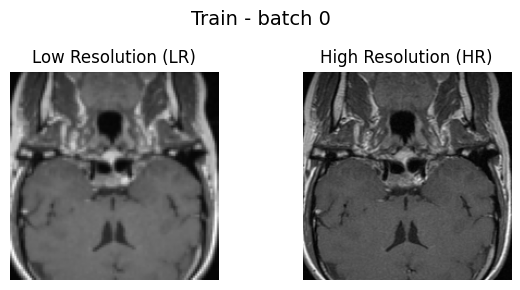

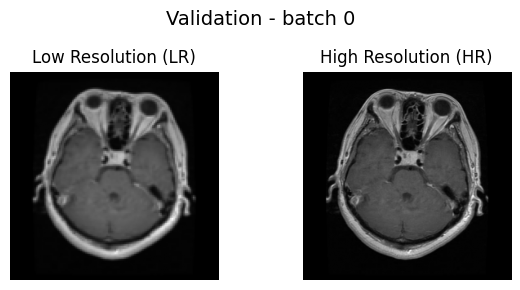

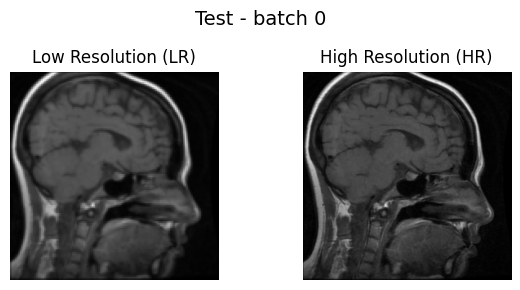

In [2]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Data Exploration                                                  ║
# ╚════════════════════════════════════════════════════════════════════╝
import matplotlib.pyplot as plt
from utils import create_dataloaders, show_sample

# Build loaders --------------------------------------------------------
train_loader, val_loader, test_loader = create_dataloaders(
    data_dir        = CFG["data"]["dir"],
    config_path     = CFG["data"]["transforms"],
    loader_to_create= "all",
    batch_size      = CFG["data"].get("preview_batch", 1),
    num_workers     = CFG["data"].get("workers", 4),
)

# Quick visual ---------------------------------------------------------
def preview(loader, title: str, max_batches: int = 1) -> None:
    """Displays batches to verify images."""
    for idx, batch in enumerate(loader):
        show_sample(batch, f"{title} - batch {idx}")
        if idx + 1 >= max_batches:
            break


preview(train_loader, "Train")
preview(val_loader,   "Validation")
preview(test_loader,  "Test")

plt.close("all")

                            Training arguments:                             
batch_size    4                                                             
checkpoint    None                                                          
config        '/home/logan/BME_5710_Project_Team_5/configs/base_config.yaml'
epochs        250                                                           
gamma         0.6                                                           
lr            0.0002                                                        
mid_channels  64                                                            
model         'willnet_se_deep'                                             
n_blocks      10                                                            
output_dir    'checkpoints/willnet_run'                                     
patience      30


Epoch 1/250


Loss ➜ train: 0.0538 | val: 0.0368 | PSNR: 33.30 | SSIM: 0.9372

Epoch 2/250


Loss ➜ train: 0.0406 | val: 0.0317 | PSNR: 34.08 | SSIM: 0.9471

Epoch 3/250


Loss ➜ train: 0.0369 | val: 0.0297 | PSNR: 34.48 | SSIM: 0.9508

Epoch 4/250


Loss ➜ train: 0.0357 | val: 0.0287 | PSNR: 34.67 | SSIM: 0.9526

Epoch 5/250


Loss ➜ train: 0.0345 | val: 0.0295 | PSNR: 34.68 | SSIM: 0.9509

Epoch 6/250


Loss ➜ train: 0.0343 | val: 0.0278 | PSNR: 34.87 | SSIM: 0.9541

Epoch 7/250


Loss ➜ train: 0.0337 | val: 0.0273 | PSNR: 35.02 | SSIM: 0.9549

Epoch 8/250


Loss ➜ train: 0.0332 | val: 0.0270 | PSNR: 35.12 | SSIM: 0.9555

Epoch 9/250


Loss ➜ train: 0.0329 | val: 0.0266 | PSNR: 35.27 | SSIM: 0.9562

Epoch 10/250


Loss ➜ train: 0.0324 | val: 0.0264 | PSNR: 35.35 | SSIM: 0.9565

Epoch 11/250


Loss ➜ train: 0.0320 | val: 0.0260 | PSNR: 35.43 | SSIM: 0.9572

Epoch 12/250


Loss ➜ train: 0.0317 | val: 0.0258 | PSNR: 35.53 | SSIM: 0.9576

Epoch 13/250


Loss ➜ train: 0.0314 | val: 0.0256 | PSNR: 35.60 | SSIM: 0.9580

Epoch 14/250


Loss ➜ train: 0.0313 | val: 0.0254 | PSNR: 35.64 | SSIM: 0.9583

Epoch 15/250


Loss ➜ train: 0.0313 | val: 0.0254 | PSNR: 35.62 | SSIM: 0.9585

Epoch 16/250


Loss ➜ train: 0.0310 | val: 0.0251 | PSNR: 35.72 | SSIM: 0.9590

Epoch 17/250


Loss ➜ train: 0.0305 | val: 0.0250 | PSNR: 35.74 | SSIM: 0.9590

Epoch 18/250


Loss ➜ train: 0.0308 | val: 0.0249 | PSNR: 35.79 | SSIM: 0.9592

Epoch 19/250


Loss ➜ train: 0.0303 | val: 0.0248 | PSNR: 35.80 | SSIM: 0.9594

Epoch 20/250


Loss ➜ train: 0.0301 | val: 0.0246 | PSNR: 35.87 | SSIM: 0.9597

Epoch 21/250


Loss ➜ train: 0.0300 | val: 0.0245 | PSNR: 35.91 | SSIM: 0.9598

Epoch 22/250


Loss ➜ train: 0.0298 | val: 0.0245 | PSNR: 35.92 | SSIM: 0.9600

Epoch 23/250


Loss ➜ train: 0.0298 | val: 0.0244 | PSNR: 35.92 | SSIM: 0.9602

Epoch 24/250


Loss ➜ train: 0.0297 | val: 0.0243 | PSNR: 35.95 | SSIM: 0.9602

Epoch 25/250


Loss ➜ train: 0.0296 | val: 0.0242 | PSNR: 35.98 | SSIM: 0.9604

Epoch 26/250


Loss ➜ train: 0.0298 | val: 0.0242 | PSNR: 35.96 | SSIM: 0.9604

Epoch 27/250


Loss ➜ train: 0.0297 | val: 0.0242 | PSNR: 35.98 | SSIM: 0.9604

Epoch 28/250


Loss ➜ train: 0.0295 | val: 0.0241 | PSNR: 36.04 | SSIM: 0.9607

Epoch 29/250


Loss ➜ train: 0.0294 | val: 0.0241 | PSNR: 36.03 | SSIM: 0.9606

Epoch 30/250


Loss ➜ train: 0.0293 | val: 0.0241 | PSNR: 36.06 | SSIM: 0.9606

Epoch 31/250


Loss ➜ train: 0.0293 | val: 0.0241 | PSNR: 36.05 | SSIM: 0.9607

Epoch 32/250


Loss ➜ train: 0.0292 | val: 0.0239 | PSNR: 36.09 | SSIM: 0.9609

Epoch 33/250


Loss ➜ train: 0.0293 | val: 0.0241 | PSNR: 36.06 | SSIM: 0.9606

Epoch 34/250


Loss ➜ train: 0.0291 | val: 0.0239 | PSNR: 36.12 | SSIM: 0.9609

Epoch 35/250


Loss ➜ train: 0.0291 | val: 0.0240 | PSNR: 36.11 | SSIM: 0.9608

Epoch 36/250


Loss ➜ train: 0.0292 | val: 0.0238 | PSNR: 36.16 | SSIM: 0.9612

Epoch 37/250


Loss ➜ train: 0.0290 | val: 0.0237 | PSNR: 36.14 | SSIM: 0.9612

Epoch 38/250


Loss ➜ train: 0.0289 | val: 0.0239 | PSNR: 36.11 | SSIM: 0.9611

Epoch 39/250


Loss ➜ train: 0.0291 | val: 0.0238 | PSNR: 36.14 | SSIM: 0.9612

Epoch 40/250


Loss ➜ train: 0.0290 | val: 0.0237 | PSNR: 36.13 | SSIM: 0.9613

Epoch 41/250


Loss ➜ train: 0.0290 | val: 0.0240 | PSNR: 36.10 | SSIM: 0.9607

Epoch 42/250


Loss ➜ train: 0.0289 | val: 0.0237 | PSNR: 36.18 | SSIM: 0.9614

Epoch 43/250


Loss ➜ train: 0.0289 | val: 0.0236 | PSNR: 36.22 | SSIM: 0.9614

Epoch 44/250


Loss ➜ train: 0.0288 | val: 0.0236 | PSNR: 36.22 | SSIM: 0.9614

Epoch 45/250


Loss ➜ train: 0.0287 | val: 0.0237 | PSNR: 36.17 | SSIM: 0.9614

Epoch 46/250


Loss ➜ train: 0.0288 | val: 0.0235 | PSNR: 36.24 | SSIM: 0.9616

Epoch 47/250


Loss ➜ train: 0.0288 | val: 0.0236 | PSNR: 36.21 | SSIM: 0.9614

Epoch 48/250


Loss ➜ train: 0.0287 | val: 0.0236 | PSNR: 36.22 | SSIM: 0.9615

Epoch 49/250


Loss ➜ train: 0.0285 | val: 0.0236 | PSNR: 36.23 | SSIM: 0.9615

Epoch 50/250


Loss ➜ train: 0.0286 | val: 0.0236 | PSNR: 36.21 | SSIM: 0.9615

Epoch 51/250


Loss ➜ train: 0.0287 | val: 0.0235 | PSNR: 36.24 | SSIM: 0.9617

Epoch 52/250


Loss ➜ train: 0.0286 | val: 0.0234 | PSNR: 36.25 | SSIM: 0.9618

Epoch 53/250


Loss ➜ train: 0.0284 | val: 0.0234 | PSNR: 36.27 | SSIM: 0.9619

Epoch 54/250


Loss ➜ train: 0.0283 | val: 0.0236 | PSNR: 36.17 | SSIM: 0.9616

Epoch 55/250


Loss ➜ train: 0.0286 | val: 0.0234 | PSNR: 36.27 | SSIM: 0.9618

Epoch 56/250


Loss ➜ train: 0.0283 | val: 0.0234 | PSNR: 36.32 | SSIM: 0.9619

Epoch 57/250


Loss ➜ train: 0.0286 | val: 0.0234 | PSNR: 36.29 | SSIM: 0.9619

Epoch 58/250


Loss ➜ train: 0.0284 | val: 0.0233 | PSNR: 36.31 | SSIM: 0.9619

Epoch 59/250


Loss ➜ train: 0.0284 | val: 0.0233 | PSNR: 36.28 | SSIM: 0.9619

Epoch 60/250


Loss ➜ train: 0.0283 | val: 0.0233 | PSNR: 36.29 | SSIM: 0.9619

Epoch 61/250


Loss ➜ train: 0.0284 | val: 0.0233 | PSNR: 36.29 | SSIM: 0.9620

Epoch 62/250


Loss ➜ train: 0.0282 | val: 0.0233 | PSNR: 36.30 | SSIM: 0.9621

Epoch 63/250


Loss ➜ train: 0.0284 | val: 0.0233 | PSNR: 36.31 | SSIM: 0.9621

Epoch 64/250


Loss ➜ train: 0.0283 | val: 0.0233 | PSNR: 36.27 | SSIM: 0.9620

Epoch 65/250


Loss ➜ train: 0.0283 | val: 0.0232 | PSNR: 36.35 | SSIM: 0.9622

Epoch 66/250


Loss ➜ train: 0.0282 | val: 0.0233 | PSNR: 36.27 | SSIM: 0.9620

Epoch 67/250


Loss ➜ train: 0.0283 | val: 0.0232 | PSNR: 36.33 | SSIM: 0.9621

Epoch 68/250


Loss ➜ train: 0.0283 | val: 0.0232 | PSNR: 36.36 | SSIM: 0.9621

Epoch 69/250


Loss ➜ train: 0.0282 | val: 0.0233 | PSNR: 36.24 | SSIM: 0.9621

Epoch 70/250


Loss ➜ train: 0.0282 | val: 0.0232 | PSNR: 36.33 | SSIM: 0.9621

Epoch 71/250


Loss ➜ train: 0.0281 | val: 0.0231 | PSNR: 36.35 | SSIM: 0.9623

Epoch 72/250


Loss ➜ train: 0.0282 | val: 0.0232 | PSNR: 36.36 | SSIM: 0.9622

Epoch 73/250


Loss ➜ train: 0.0283 | val: 0.0232 | PSNR: 36.37 | SSIM: 0.9622

Epoch 74/250


Loss ➜ train: 0.0280 | val: 0.0232 | PSNR: 36.36 | SSIM: 0.9622

Epoch 75/250


Loss ➜ train: 0.0281 | val: 0.0233 | PSNR: 36.28 | SSIM: 0.9621

Epoch 76/250


Loss ➜ train: 0.0282 | val: 0.0231 | PSNR: 36.39 | SSIM: 0.9624

Epoch 77/250


Loss ➜ train: 0.0281 | val: 0.0232 | PSNR: 36.34 | SSIM: 0.9623

Epoch 78/250


Loss ➜ train: 0.0280 | val: 0.0231 | PSNR: 36.40 | SSIM: 0.9624

Epoch 79/250


Loss ➜ train: 0.0279 | val: 0.0231 | PSNR: 36.38 | SSIM: 0.9623

Epoch 80/250


Loss ➜ train: 0.0281 | val: 0.0232 | PSNR: 36.34 | SSIM: 0.9623

Epoch 81/250


Loss ➜ train: 0.0278 | val: 0.0231 | PSNR: 36.38 | SSIM: 0.9624

Epoch 82/250


Loss ➜ train: 0.0281 | val: 0.0231 | PSNR: 36.38 | SSIM: 0.9624

Epoch 83/250


Loss ➜ train: 0.0280 | val: 0.0232 | PSNR: 36.37 | SSIM: 0.9620

Epoch 84/250


Loss ➜ train: 0.0282 | val: 0.0231 | PSNR: 36.39 | SSIM: 0.9624

Epoch 85/250


Loss ➜ train: 0.0279 | val: 0.0231 | PSNR: 36.38 | SSIM: 0.9624

Epoch 86/250


Loss ➜ train: 0.0278 | val: 0.0230 | PSNR: 36.40 | SSIM: 0.9625

Epoch 87/250


Loss ➜ train: 0.0279 | val: 0.0231 | PSNR: 36.40 | SSIM: 0.9624

Epoch 88/250


Loss ➜ train: 0.0279 | val: 0.0231 | PSNR: 36.39 | SSIM: 0.9624

Epoch 89/250


Loss ➜ train: 0.0279 | val: 0.0230 | PSNR: 36.39 | SSIM: 0.9624

Epoch 90/250


Loss ➜ train: 0.0279 | val: 0.0230 | PSNR: 36.41 | SSIM: 0.9626

Epoch 91/250


Loss ➜ train: 0.0279 | val: 0.0230 | PSNR: 36.42 | SSIM: 0.9625

Epoch 92/250


Loss ➜ train: 0.0277 | val: 0.0230 | PSNR: 36.39 | SSIM: 0.9625

Epoch 93/250


Loss ➜ train: 0.0280 | val: 0.0230 | PSNR: 36.41 | SSIM: 0.9625

Epoch 94/250


Loss ➜ train: 0.0278 | val: 0.0230 | PSNR: 36.43 | SSIM: 0.9625

Epoch 95/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.43 | SSIM: 0.9626

Epoch 96/250


Loss ➜ train: 0.0279 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9627

Epoch 97/250


Loss ➜ train: 0.0278 | val: 0.0230 | PSNR: 36.44 | SSIM: 0.9625

Epoch 98/250


Loss ➜ train: 0.0277 | val: 0.0230 | PSNR: 36.43 | SSIM: 0.9626

Epoch 99/250


Loss ➜ train: 0.0278 | val: 0.0230 | PSNR: 36.43 | SSIM: 0.9626

Epoch 100/250


Loss ➜ train: 0.0277 | val: 0.0230 | PSNR: 36.40 | SSIM: 0.9625

Epoch 101/250


Loss ➜ train: 0.0276 | val: 0.0230 | PSNR: 36.43 | SSIM: 0.9625

Epoch 102/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.43 | SSIM: 0.9627

Epoch 103/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.45 | SSIM: 0.9627

Epoch 104/250


Loss ➜ train: 0.0279 | val: 0.0229 | PSNR: 36.43 | SSIM: 0.9627

Epoch 105/250


Loss ➜ train: 0.0277 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 106/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 107/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 108/250


Loss ➜ train: 0.0275 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 109/250


Loss ➜ train: 0.0277 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9628

Epoch 110/250


Loss ➜ train: 0.0277 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9627

Epoch 111/250


Loss ➜ train: 0.0277 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 112/250


Loss ➜ train: 0.0278 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9628

Epoch 113/250


Loss ➜ train: 0.0277 | val: 0.0228 | PSNR: 36.45 | SSIM: 0.9628

Epoch 114/250


Loss ➜ train: 0.0276 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9628

Epoch 115/250


Loss ➜ train: 0.0277 | val: 0.0229 | PSNR: 36.48 | SSIM: 0.9628

Epoch 116/250


Loss ➜ train: 0.0275 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9627

Epoch 117/250


Loss ➜ train: 0.0275 | val: 0.0229 | PSNR: 36.46 | SSIM: 0.9627

Epoch 118/250


Loss ➜ train: 0.0275 | val: 0.0228 | PSNR: 36.46 | SSIM: 0.9628

Epoch 119/250


Loss ➜ train: 0.0276 | val: 0.0228 | PSNR: 36.47 | SSIM: 0.9628

Epoch 120/250


Loss ➜ train: 0.0276 | val: 0.0229 | PSNR: 36.47 | SSIM: 0.9628

Epoch 121/250


Loss ➜ train: 0.0275 | val: 0.0228 | PSNR: 36.48 | SSIM: 0.9628

Epoch 122/250


Loss ➜ train: 0.0278 | val: 0.0228 | PSNR: 36.51 | SSIM: 0.9629

Epoch 123/250


Loss ➜ train: 0.0276 | val: 0.0228 | PSNR: 36.49 | SSIM: 0.9628

Epoch 124/250


Loss ➜ train: 0.0276 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9628

Epoch 125/250


Loss ➜ train: 0.0274 | val: 0.0228 | PSNR: 36.48 | SSIM: 0.9628

Epoch 126/250


Loss ➜ train: 0.0274 | val: 0.0228 | PSNR: 36.48 | SSIM: 0.9628

Epoch 127/250


Loss ➜ train: 0.0275 | val: 0.0229 | PSNR: 36.44 | SSIM: 0.9627

Epoch 128/250


Loss ➜ train: 0.0276 | val: 0.0228 | PSNR: 36.51 | SSIM: 0.9629

Epoch 129/250


Loss ➜ train: 0.0278 | val: 0.0228 | PSNR: 36.48 | SSIM: 0.9629

Epoch 130/250


Loss ➜ train: 0.0276 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9629

Epoch 131/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9630

Epoch 132/250


Loss ➜ train: 0.0277 | val: 0.0228 | PSNR: 36.49 | SSIM: 0.9628

Epoch 133/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 134/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 135/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.51 | SSIM: 0.9630

Epoch 136/250


Loss ➜ train: 0.0275 | val: 0.0228 | PSNR: 36.51 | SSIM: 0.9629

Epoch 137/250


Loss ➜ train: 0.0276 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 138/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9630

Epoch 139/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.49 | SSIM: 0.9630

Epoch 140/250


Loss ➜ train: 0.0273 | val: 0.0228 | PSNR: 36.50 | SSIM: 0.9630

Epoch 141/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 142/250


Loss ➜ train: 0.0275 | val: 0.0228 | PSNR: 36.50 | SSIM: 0.9630

Epoch 143/250


Loss ➜ train: 0.0275 | val: 0.0228 | PSNR: 36.51 | SSIM: 0.9630

Epoch 144/250


Loss ➜ train: 0.0274 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 145/250


Loss ➜ train: 0.0274 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 146/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 147/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9630

Epoch 148/250


Loss ➜ train: 0.0272 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9630

Epoch 149/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 150/250


Loss ➜ train: 0.0274 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 151/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9629

Epoch 152/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9630

Epoch 153/250


Loss ➜ train: 0.0274 | val: 0.0228 | PSNR: 36.50 | SSIM: 0.9629

Epoch 154/250


Loss ➜ train: 0.0274 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 155/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9631

Epoch 156/250


Loss ➜ train: 0.0272 | val: 0.0227 | PSNR: 36.50 | SSIM: 0.9630

Epoch 157/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.51 | SSIM: 0.9629

Epoch 158/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.52 | SSIM: 0.9630

Epoch 159/250


Loss ➜ train: 0.0274 | val: 0.0228 | PSNR: 36.51 | SSIM: 0.9628

Epoch 160/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9630

Epoch 161/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9631

Epoch 162/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9631

Epoch 163/250


Loss ➜ train: 0.0272 | val: 0.0227 | PSNR: 36.56 | SSIM: 0.9630

Epoch 164/250


Loss ➜ train: 0.0275 | val: 0.0227 | PSNR: 36.53 | SSIM: 0.9631

Epoch 165/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.55 | SSIM: 0.9631

Epoch 166/250


Loss ➜ train: 0.0274 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9631

Epoch 167/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9631

Epoch 168/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.51 | SSIM: 0.9630

Epoch 169/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.55 | SSIM: 0.9631

Epoch 170/250


Loss ➜ train: 0.0274 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9631

Epoch 171/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.55 | SSIM: 0.9631

Epoch 172/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.54 | SSIM: 0.9631

Epoch 173/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 174/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9632

Epoch 175/250


Loss ➜ train: 0.0274 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 176/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9631

Epoch 177/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.55 | SSIM: 0.9631

Epoch 178/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.54 | SSIM: 0.9631

Epoch 179/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 180/250


Loss ➜ train: 0.0273 | val: 0.0227 | PSNR: 36.54 | SSIM: 0.9631

Epoch 181/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 182/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 183/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9631

Epoch 184/250


Loss ➜ train: 0.0274 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 185/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9631

Epoch 186/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 187/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 188/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 189/250


Loss ➜ train: 0.0274 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9632

Epoch 190/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 191/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9632

Epoch 192/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 193/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 194/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.55 | SSIM: 0.9631

Epoch 195/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 196/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 197/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9632

Epoch 198/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 199/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 200/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 201/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 202/250


Loss ➜ train: 0.0270 | val: 0.0226 | PSNR: 36.56 | SSIM: 0.9632

Epoch 203/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.59 | SSIM: 0.9632

Epoch 204/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 205/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 206/250


Loss ➜ train: 0.0274 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 207/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.57 | SSIM: 0.9632

Epoch 208/250


Loss ➜ train: 0.0272 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9632

Epoch 209/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 210/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9633

Epoch 211/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633

Epoch 212/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 213/250


Loss ➜ train: 0.0272 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9632

Epoch 214/250


Loss ➜ train: 0.0273 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9633

Epoch 215/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633

Epoch 216/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 217/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 218/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 219/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 220/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.58 | SSIM: 0.9633

Epoch 221/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.59 | SSIM: 0.9633

Epoch 222/250


Loss ➜ train: 0.0269 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9633

Epoch 223/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 224/250


Loss ➜ train: 0.0272 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 225/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 226/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 227/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.58 | SSIM: 0.9633

Epoch 228/250


Loss ➜ train: 0.0272 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 229/250


Loss ➜ train: 0.0268 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 230/250


Loss ➜ train: 0.0269 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 231/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 232/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 233/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.58 | SSIM: 0.9633

Epoch 234/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.60 | SSIM: 0.9633

Epoch 235/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 236/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.59 | SSIM: 0.9633

Epoch 237/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 238/250


Loss ➜ train: 0.0271 | val: 0.0226 | PSNR: 36.58 | SSIM: 0.9633

Epoch 239/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 240/250


Loss ➜ train: 0.0273 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 241/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 242/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633

Epoch 243/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633

Epoch 244/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.59 | SSIM: 0.9633

Epoch 245/250


Loss ➜ train: 0.0270 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 246/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 247/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.58 | SSIM: 0.9633

Epoch 248/250


Loss ➜ train: 0.0271 | val: 0.0225 | PSNR: 36.60 | SSIM: 0.9633

Epoch 249/250


Loss ➜ train: 0.0272 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633

Epoch 250/250


Loss ➜ train: 0.0269 | val: 0.0225 | PSNR: 36.61 | SSIM: 0.9633
Training complete. Best val loss: 0.0225


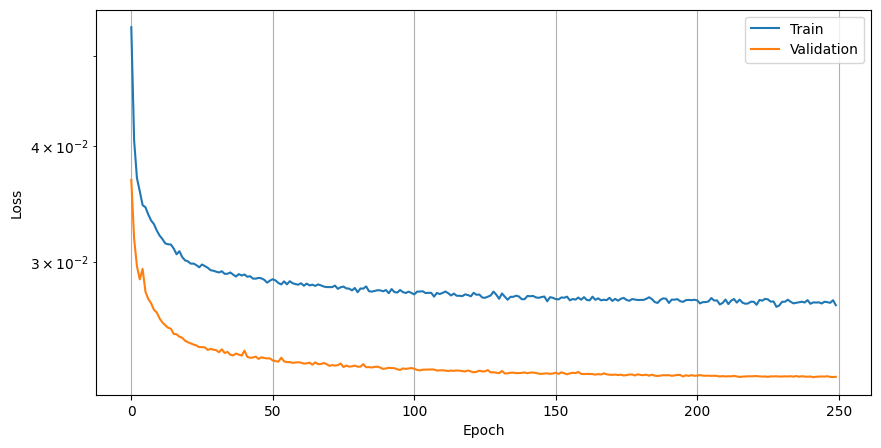

Training complete in 39.1 min

In [3]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Model Training                                                    ║
# ╚════════════════════════════════════════════════════════════════════╝
import time
from types import SimpleNamespace

from utils import display_args
from train import Trainer

# Build training arguments ---------------------------------------------
train_kwargs: dict = {
    **CFG["train"],
    "config": str(BASE_CFG),
}

train_args = SimpleNamespace(**train_kwargs)
display_args(train_args, title="Training arguments:", indent=2, padding=14)

# Run training & time it -----------------------------------------------
start = time.perf_counter()

trainer = Trainer(train_args)
trainer.fit()

elapsed = time.perf_counter() - start
print(f"Training complete in {elapsed/60:.1f} min")


                                Evaluation arguments                                
batch_size    1                                                                     
checkpoint    'checkpoints/willnet_run/willnet_se_deep_best.pth'                    
config        '/home/logan/BME_5710_Project_Team_5/configs/experiments/willnet.yaml'
mid_channels  64                                                                    
model         'willnet_se_deep'                                                     
n_blocks      10                                                                    
output_dir    'results/willnet_run'                                                 
save_visual   True

Metric      Bicubic (↑)    Super-Res (↑)    Improvement
--------  -------------  ---------------  -------------
PSNR            30.7101          36.5477         5.8375
SSIM             0.913            0.9684         0.0554


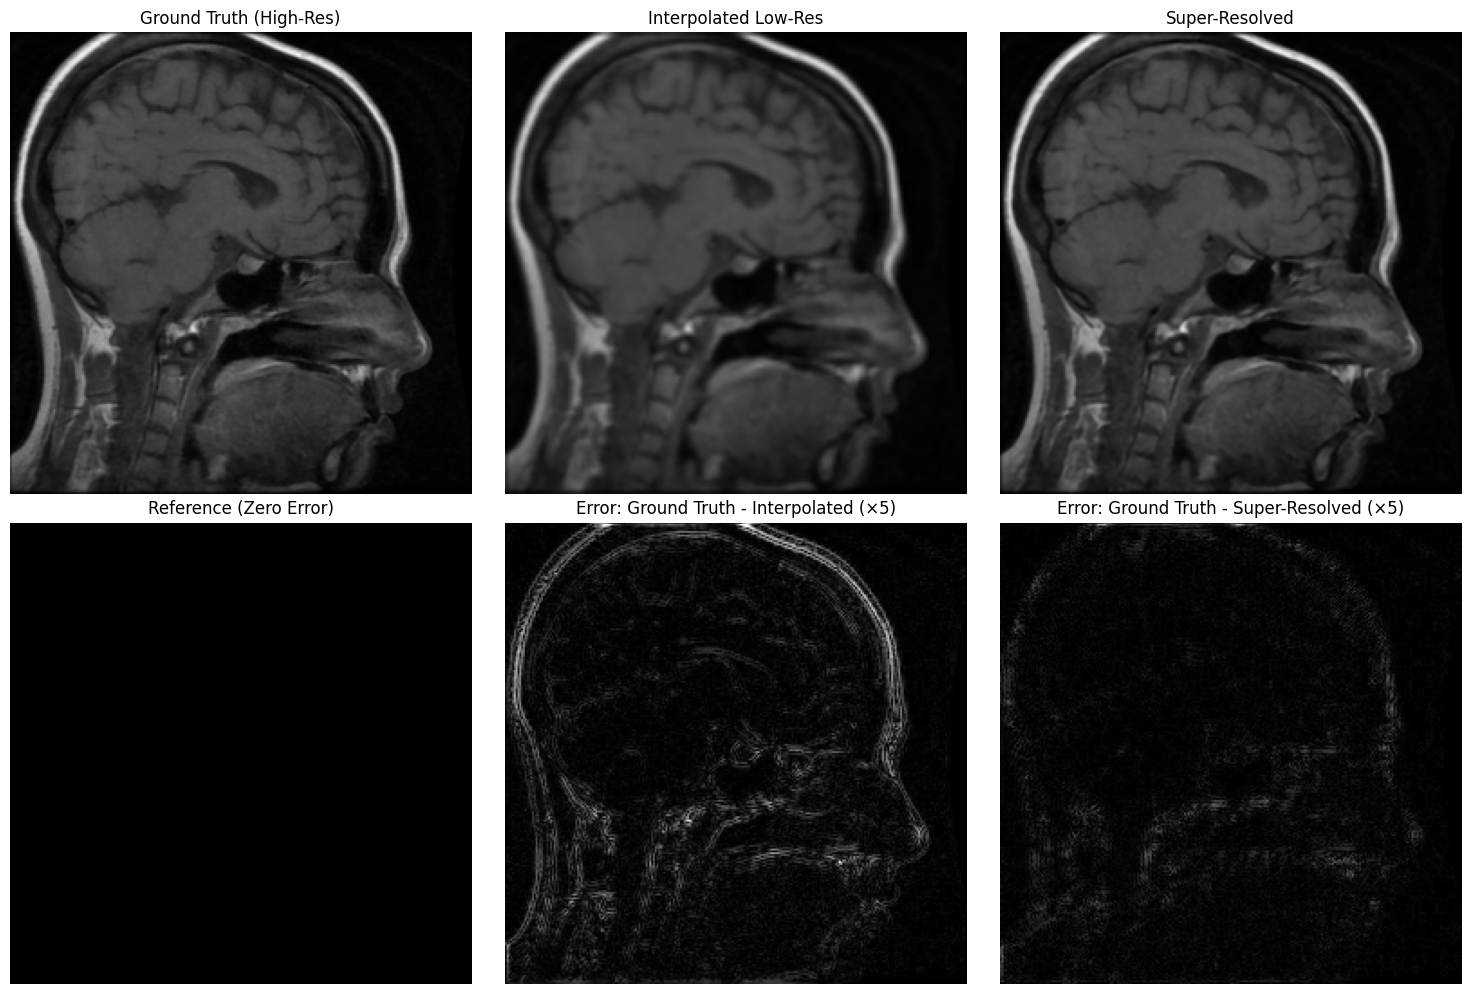

In [8]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Model Evaluation                                                  ║
# ╚════════════════════════════════════════════════════════════════════╝
from evaluate import Evaluator

# Build evaluation arguments -------------------------------------------
eval_kwargs: dict = {
    **CFG["eval"],
    "config":     str(EXP_CFG),
    "checkpoint": str(trainer.output_dir / f"{train_args.model}_best.pth"),
}

eval_args = SimpleNamespace(**eval_kwargs)
display_args(eval_args, title="Evaluation arguments", indent=2, padding=14)

# Run evaluation -------------------------------------------------------
evaluator = Evaluator(eval_args)
metrics: dict = evaluator.run()
